# Importação das Bibliotecas

In [1]:
# Pacotes de preparação dos dados
import numpy as np
import pandas as pd

# Pacotes gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Pacotes de modelagem
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Importação da base de dados

In [2]:
df = pd.read_csv(f'pagamento.csv',sep=',')

# Análise Exploratória

In [3]:
print(df.info())

print('\n Number of unique values in each column')
for i in df.columns:
    print(f'{i} - {df[i].nunique()}')
    
print('\nNumber of missing values in each column\n',df.isnull().sum())

print('\nNumber of duplicated lines =',df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Pagou_Divida     400 non-null    int64  
 1   Renda_Presumida  400 non-null    float64
 2   Idade            400 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 9.5 KB
None

 Number of unique values in each column
Pagou_Divida - 2
Renda_Presumida - 117
Idade - 43

Number of missing values in each column
 Pagou_Divida       0
Renda_Presumida    0
Idade              0
dtype: int64

Number of duplicated lines = 33


#### Nessa análise, optou-se por excluir os valores duplicados

In [4]:
df.drop_duplicates(inplace=True)

In [7]:
print('Number of duplicated lines =',df.duplicated().sum())

Number of duplicated lines = 0


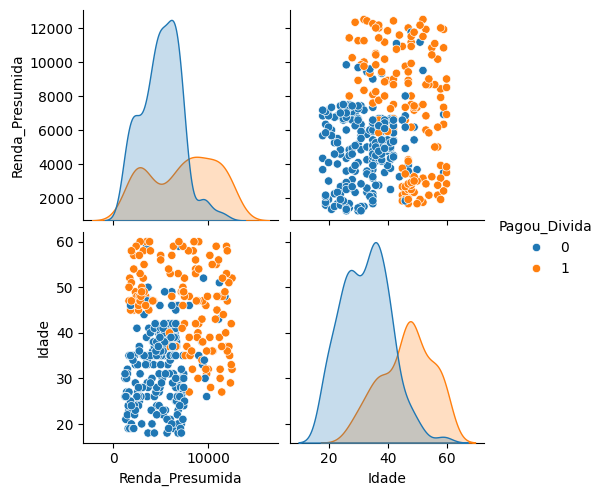

In [9]:
sns.pairplot(df, 
             hue='Pagou_Divida');

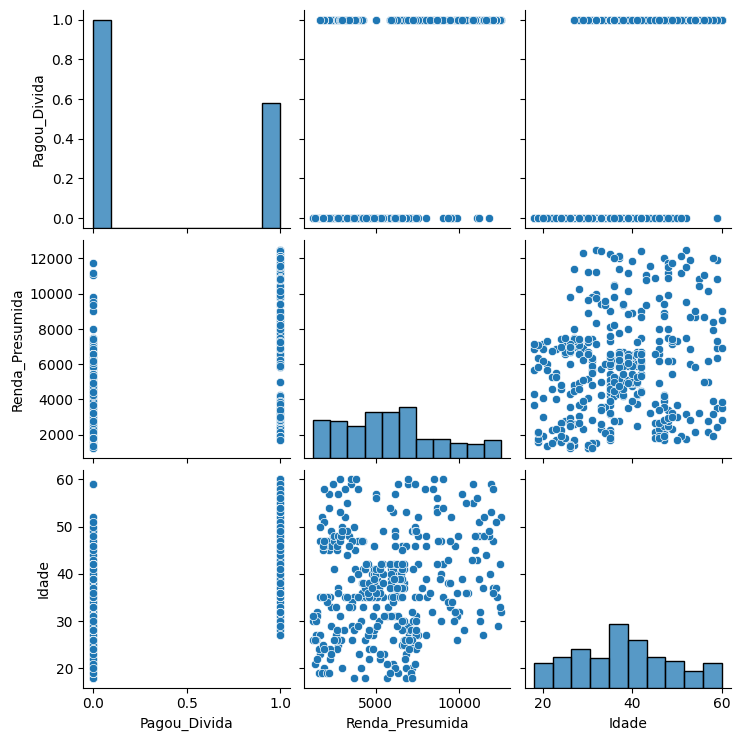

In [11]:
sns.pairplot(df)

# Desenvolvimento do Modelo: K-Means

### Padronização da Escala

In [12]:
# Seleção das variáveis
df_modelo = df[['Renda_Presumida', 
                    'Idade']].copy()

# Padronização da Escala
x_scaler = StandardScaler()
x_scaler.fit(df_modelo)

df_modelo_scaled = pd.DataFrame(x_scaler.transform(df_modelo),
                                index=df_modelo.index,
                                columns=df_modelo.columns)

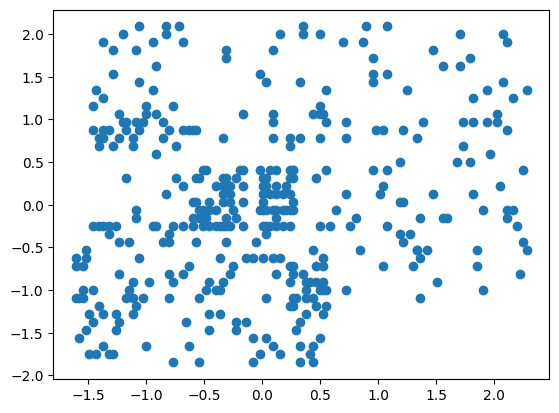

In [13]:
# Plotando Renda Presumida por Idade
plt.scatter(df_modelo_scaled['Renda_Presumida'],
            df_modelo_scaled['Idade']);

# Treinamento do Modelo
`Dica:` Utilizar a função treina_modelo_kmeans para facilitar o treinamento e avaliação dos modelos com diferentes quantidades de clusters.

In [18]:
def treina_modelo_kmeans(df_scaled, k, plota_grafico=False):
    
    # Define e treina um modelo K-means
    modelo_km = KMeans(n_clusters=k, 
                       random_state=42)
    modelo_km.fit(df_scaled)
    
    # Obtém os clusters preditos
    cluster_predito = modelo_km.predict(df_scaled)
    
    # Plota os gráficos
    if plota_grafico:
        fig = plt.figure(figsize=(8,8))
        sns.scatterplot(x=df_scaled.iloc[:,0],                    
                        y=df_scaled.iloc[:,1],                    
                        hue=cluster_predito)
        
        sns.scatterplot(x=modelo_km.cluster_centers_[:,0],
                        y=modelo_km.cluster_centers_[:,1], 
                        marker='x', s=300, 
                        linewidth=4, color='red', zorder=10);

    return modelo_km , cluster_predito

## Modelo com 3 clusters

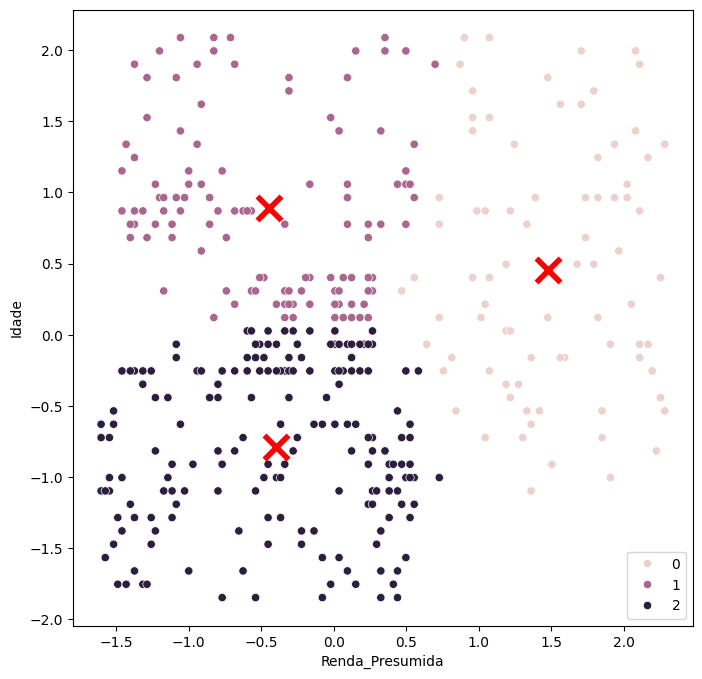

In [23]:
modelo_km3, cluster_predito = treina_modelo_kmeans(df_scaled=df_modelo_scaled, 
                                                   k=3, 
                                                   plota_grafico=True)

### Identificação do número de clusters

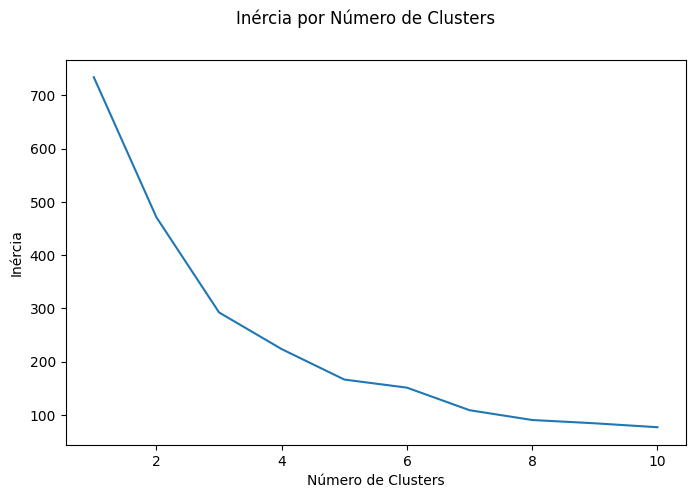

In [21]:
# Utilizando o Método do Cotovelo (Elbow-curve)
range_n_clusters = np.arange(1, 11)
inercia = []
n_clust = []

for num_clusters in range_n_clusters:
    n_clust.append(num_clusters)
    modelo, clust_pred = treina_modelo_kmeans(df_modelo_scaled, 
                                              k=num_clusters)
    inercia.append(modelo.inertia_)

fig = plt.figure(figsize=(8,5))
graf = sns.lineplot(x=n_clust, y=inercia);
graf.figure.suptitle('Inércia por Número de Clusters');
graf.set_xlabel('Número de Clusters');
graf.set_ylabel('Inércia');

### Interpretação e Caracterização dos Clusters
**ATENÇÃO**: deve-se utilizar o método `predict` do modelo desenvolvido sobre o **DataFrame com as variáveis padronizadas** para identificar os clusters das observações no DataFrame original.

In [24]:
df_modelo['cluster'] = cluster_predito

In [25]:
df_modelo.groupby('cluster').describe().T

cluster                           0            1            2
Renda_Presumida count     81.000000   112.000000   174.000000
                mean   10177.984074  4597.470714  4732.758678
                std     1436.730220  1792.644237  1926.146958
                min     7250.000000  1666.670000  1250.000000
                25%     9000.000000  2979.167500  3020.832500
                50%    10000.000000  4833.335000  4916.670000
                75%    11416.670000  6166.670000  6416.670000
                max    12500.000000  7916.670000  8000.000000
Idade           count     81.000000   112.000000   174.000000
                mean      42.604938    47.232143    29.327586
                std        9.261046     6.351537     5.936235
                min       26.000000    39.000000    18.000000
                25%       35.000000    41.000000    25.000000
                50%       42.000000    47.000000    29.000000
                75%       49.000000    50.250000    35.000000
                max       60.000000    60.000000    38.000000

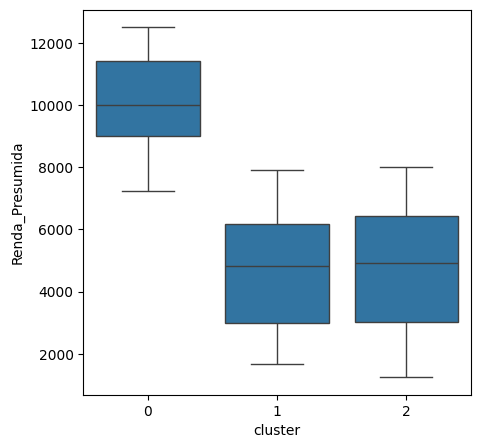

In [27]:
# Análise dos clusters em relação a Renda Presumida
fig = plt.figure(figsize=(5,5))
sns.boxplot(x='cluster',
            y='Renda_Presumida', 
            data=df_modelo);

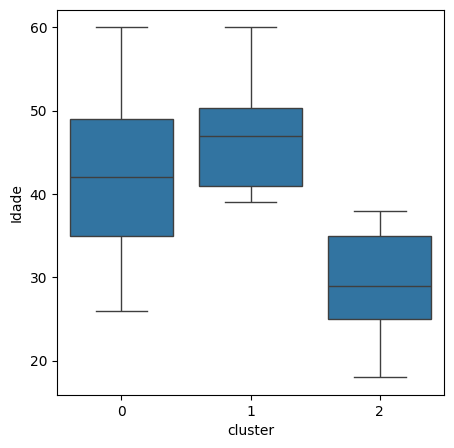

In [28]:
# Análise dos clusters em relação a Idade
fig = plt.figure(figsize=(5,5))
sns.boxplot(x='cluster',
            y='Idade', 
            data=df_modelo);

### Avaliação dos Clusters em relação ao Pagamento
Como nesta base foram fornecidas as informações de Pagamento, avaliou-se também o percentual de clientes que pagou as dívidas em cada um dos clusters.

In [30]:
df_cluster_divida = pd.concat([df_modelo[['cluster']],
                               df[['Pagou_Divida']]], 
                              axis=1)
df_cluster_divida.head()

,cluster,Pagou_Divida
0,2,0
1,2,0
2,2,0
3,2,0
4,2,0


In [31]:
df_cluster_divida.pivot_table(values='Pagou_Divida', 
                              index='cluster')

,Pagou_Divida
cluster,
0,0.851852
1,0.571429
2,0.028736


### **Análise dos Resultados do Modelo K-Means**

A análise do modelo K-Means agrupou os clientes com base no comportamento de pagamento de dívidas na empresa, produzindo três clusters com as seguintes médias de pagamento:

| Cluster | Taxa de Pagamento (%) |
| ------- | --------------------- |
| **0**   | 85,19%                |
| **1**   | 57,14%                |
| **2**   | 2,87%                 |

#### **Interpretação dos Dados**

1. **Cluster 0 - Bons Pagadores (85,19%)**
    
    - Este grupo apresenta uma taxa de pagamento extremamente alta.
    - Clientes nesse cluster são confiáveis e contribuem positivamente para o fluxo de caixa da empresa.
2. **Cluster 1 - Pagadores Medianos (57,14%)**
    
    - Clientes desse grupo têm uma taxa de pagamento moderada.
    - Representam risco intermediário: podem atrasar pagamentos, mas não são inadimplentes crônicos.
3. **Cluster 2 - Maus Pagadores (2,87%)**
    
    - Este é o grupo mais crítico.
    - Com uma taxa de pagamento extremamente baixa, clientes deste cluster provavelmente estão inadimplentes ou atrasam sistematicamente.
    - Esse comportamento pode prejudicar o fluxo de caixa e aumentar custos operacionais, como cobranças.